# Convolution layer

Digital images have [multiple channels](https://en.wikipedia.org/wiki/Channel_(digital_image)). The **convolution layer** extends the convolution operation to handle feature maps with multiple **channels**. The output feature map similarly has channels adding a further semantic dimension to the downstream representation. For an RGB image, a convolution layer learns three 2-dimensional kernels $\boldsymbol{\mathsf{K}}_{lc}$ for each output channel, each of which can be thought of as a **feature extractor**. Features across input channels are blended by the kernel:

$$
\begin{aligned}
{\bar{\boldsymbol{\mathsf X}}}_{lij}
&= {\boldsymbol{\mathsf u}}_{l} + \sum_{c=0}^{{c}_\text{in}-1} ({\boldsymbol{\mathsf X}}_{[c,\,:,\, :]} \circledast {\boldsymbol{\mathsf K}}_{[l,\,{c},\, :,\,:]})_{ij} \\
&= {\boldsymbol{\mathsf u}}_{l} + \sum_{c=0}^{{c}_\text{in}-1}\sum_{x = 0}^{{k}-1} \sum_{y=0}^{{k}-1} {\boldsymbol{\mathsf X}}_{c,\, i + x,\, j + y} \, {\boldsymbol{\mathsf K}}_{lcxy} \\
\end{aligned}
$$

for $l = 0, \ldots, {c}_\text{out}-1$. The input and output tensors $\boldsymbol{\mathsf{X}}$ and $\bar{\boldsymbol{\mathsf{X}}}$ have the same dimensionality and semantic structure which makes sense since we want to stack convolutional layers as modules, and the kernel $\boldsymbol{\mathsf{K}}$ has shape $({c}_\text{out}, {c}_\text{in}, {k}, {k}).$ The resulting feature maps inherit the spatial ordering in its inputs along the spatial dimensions. The entire operation is linear and each convolution operation is independent for each output channel. 

**Remark.** This form is called two-dimensional convolution since the kernel scans two dimensions. Meanwhile, one-dimensional convolutions can be used to process sequential data. In principle, we can add as many dimensions as required.

## Input and output channels

In [1]:
%%save
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib_inline import backend_inline

import torch
import torch.nn as nn
import torch.nn.functional as F

DATASET_DIR = Path("./data/").resolve()
DATASET_DIR.mkdir(exist_ok=True)
warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats("svg")
matplotlib.rcParams["image.interpolation"] = "nearest"

RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib_inline import backend_inline

import torch
import torch.nn as nn
import torch.nn.functional as F

DATASET_DIR = Path("./data/").resolve()
DATASET_DIR.mkdir(exist_ok=True)
warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats("svg")
matplotlib.rcParams["image.interpolation"] = "nearest"

RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

Getting a sample image from [our repo](https://github.com/particle1331/ok-transformer):

In [2]:
!curl "https://raw.githubusercontent.com/particle1331/ok-transformer/master/docs/img/shorty.png" --output ./data/shorty.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  881k  100  881k    0     0  1331k      0 --:--:-- --:--:-- --:--:-- 1331k


Reproducing the convolution operation over input and output channels:

In [3]:
from torchvision.io import read_image
import torchvision.transforms.functional as fn

def convolve(X, K):
    """Perform 2D convolution over input."""
    h, w = K.shape
    H0, W0 = X.shape
    H1 = H0 - h + 1
    W1 = W0 - w + 1

    S = np.zeros(shape=(H1, W1))
    for i in range(H1):
        for j in range(W1):
            S[i, j] = (X[i:i+h, j:j+w] * K).sum()
    
    return torch.tensor(S)

Decomposing the feature maps:

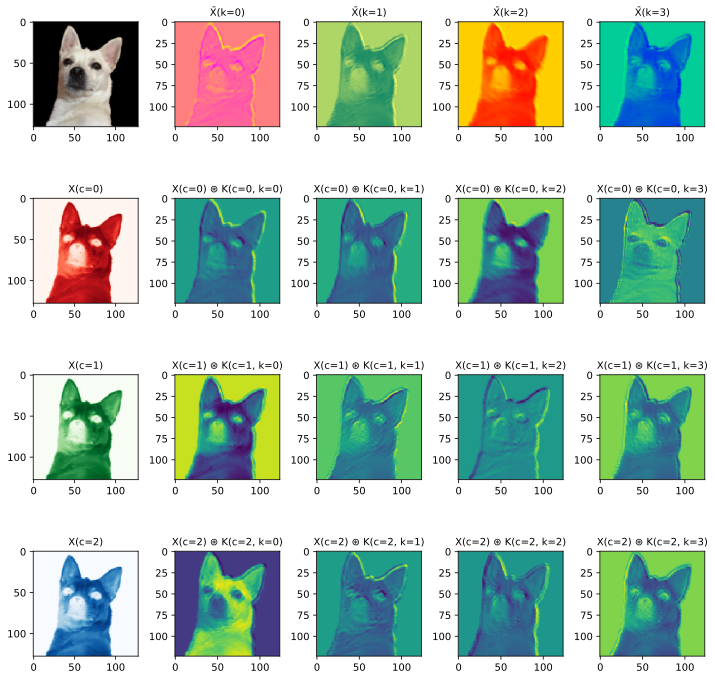

In [4]:
@torch.no_grad()
def conv_components(X, K, u):
    cmaps = ["Reds", "Greens", "Blues"]
    cmaps_out = ["spring", "summer", "autumn", "winter"]
    c_in  = X.shape[1]
    c_out = K.shape[0]
    
    fig, ax = plt.subplots(c_in + 1, c_out + 1, figsize=(10, 10))

    # Input image
    ax[0, 0].imshow(X[0].permute(1, 2, 0))
    for c in range(c_in):
        ax[c+1, 0].set_title(f"X(c={c})", size=10)
        ax[c+1, 0].imshow(X[0, c, :, :], cmap=cmaps[c])

    # Iterate over kernel filters
    out_components = {}
    for k in range(c_out):
        for c in range(c_in):
            out_components[(c, k)] = convolve(X[0, c, :, :], K[k, c, :, :])
            ax[c+1, k+1].imshow(out_components[(c, k)].numpy()) 
            ax[c+1, k+1].set_title(f"X(c={c}) ⊛ K(c={c}, k={k})", size=10)

    # Sum convolutions over input channels, then add bias
    out_maps = []
    for k in range(c_out):
        out_maps.append(sum([out_components[(c, k)] for c in range(c_in)]) + u[k])
        ax[0, k+1].imshow(out_maps[k].numpy(), cmaps_out[k])
        ax[0, k+1].set_title(r"$\bar{\mathrm{X}}$" + f"(k={k})", size=10)

    fig.tight_layout()
    return out_maps


cat = DATASET_DIR / "shorty.png"
X = read_image(str(cat)).unsqueeze(0)[:, :3, :, :]
X = fn.resize(X, size=(128, 128)) / 255.
conv = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5)
K, u = conv.weight, conv.bias
components = conv_components(X, K, u);

**Figure.** Each kernel in entries `i,j > 0` combines column-wise with the inputs to compute `X(c=i) ⊛ K(c=i, k=j)`. The sum of these terms over `c` form the output map `X̅(k=j)` above. 
This looks like computation in a fully-connected layer, but with convolutions between matrices instead of products between scalars. CNNs perform combinatorial mixing of hierarchical spatial features with depth.

Checking if the output of `conv_components` is consistent with `Conv2d` in PyTorch:

In [5]:
S = torch.stack(components).unsqueeze(0)
P = conv(X)
cmaps_out = ["spring", "summer", "autumn", "winter"]

print("Input shape: ", X.shape)   # (B, c0, H0, W0)
print("Output shape:", S.shape)   # (B, c1, H1, W1)
print("Kernel shape:", K.shape)   # (c1, c0, h, w)
print("Bias shape:  ", u.shape)   # (c1,)
print()
print("MAE (w/ pytorch) =", (S - P).abs().mean().item())

Input shape:  torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 4, 124, 124])
Kernel shape: torch.Size([4, 3, 5, 5])
Bias shape:   torch.Size([4])

MAE (w/ pytorch) = 2.424037095549667e-08
